In [196]:
import requests
from datetime import datetime
from pprint import pprint
import pandas as pd
import numpy as np
import json
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly
import xgboost as xgb
import nltk
plotly.tools.set_credentials_file(username='Him98', api_key='8uH93tZVxQ2X1b8xwy0c')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.phrases import Phraser, Phrases
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

## Part 1

In [2]:
base_url_submission = 'https://api.pushshift.io/reddit/submission/search/'
params = {'limit':'1000', 'sort':'desc', 'before':'', 'subreddit':''}

In [3]:
def get_posts(subreddit):
    params['subreddit'] = subreddit
    params['before'] = int(datetime.utcnow().timestamp())
    posts_cnt = 0
    error = False
    while True:
        try:
            if posts_cnt >= 5000:
                break
            dat = requests.get(url = base_url_submission, params = params)
            json_data = dat.json()
#             print(json_data['data'][0])
            if 'data' not in json_data or len(json_data['data']) == 0:
                break
            json_data = json_data['data']
            if 'created_utc' not in json_data[-1]:
                error = True
            else:
                params['before'] = json_data[-1]['created_utc'] - 1
            for post_json in json_data:
                if 'link_flair_css_class' not in post_json:
                    continue
                if 'selftext' not in post_json or post_json['selftext'] == '' or post_json['selftext'] == '[removed]' or post_json['selftext'] == '[deleted]':
                    continue
                posts_cnt += 1
                data['data'].append(post_json)
            print('posts_cnt: ', posts_cnt)
            print('#############')
            if len(data['data']) == 0:
                continue
#             print(posts_cnt)
        except:
            continue

In [4]:
data = {}
data['data'] = []
get_posts('india')
with open('reddit_data_new.json', 'w') as outfile:
    json.dump(data, outfile)

posts_cnt:  140
#############
posts_cnt:  264
#############
posts_cnt:  400
#############
posts_cnt:  531
#############
posts_cnt:  654
#############
posts_cnt:  778
#############
posts_cnt:  924
#############
posts_cnt:  1074
#############
posts_cnt:  1191
#############
posts_cnt:  1302
#############
posts_cnt:  1458
#############
posts_cnt:  1625
#############
posts_cnt:  1780
#############
posts_cnt:  1910
#############
posts_cnt:  2083
#############
posts_cnt:  2237
#############
posts_cnt:  2395
#############
posts_cnt:  2596
#############
posts_cnt:  2771
#############
posts_cnt:  2953
#############
posts_cnt:  3125
#############
posts_cnt:  3288
#############
posts_cnt:  3421
#############
posts_cnt:  3579
#############
posts_cnt:  3717
#############
posts_cnt:  3849
#############
posts_cnt:  3983
#############
posts_cnt:  4105
#############
posts_cnt:  4219
#############
posts_cnt:  4400
#############
posts_cnt:  4532
#############
posts_cnt:  4652
#############
posts_cnt:  476

In [5]:
len(data['data'])

5113

In [14]:
with open('reddit_data_new.json', 'r') as outfile:
    data = json.load(outfile)
df = pd.DataFrame.from_dict(data['data'])

In [18]:
df_new = df[['id', 'author', 'title','selftext', 'link_flair_css_class']]

In [21]:
df_new.to_csv('reddit_filtered.tsv', sep='\t', index=False)

## Part 2

In [12]:
def make_piechart(percent, label1, label2, title):
    color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9', 
                          '#C1F0F6', '#0099CC']
    labels = [label1, label2]
    percentages = [percent, 100-percent]
    trace = go.Pie(labels=labels,
                   hoverinfo='label+percent', 
                   values=percentages, 
                   textposition='outside',
                   marker=dict(colors=color_palette_list[0:2]),
                  rotation=90)
    layout = go.Layout(title=title,
                       font=dict(family='Arial', size=12, color='#909090'),
                       legend=dict(x=0.9, y=0.5))
    data = [trace]
    fig = go.Figure(data=data, layout=layout)
    return fig

In [13]:
def make_barplot(array, title, xlabel, ylabel, max_val):
    color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9', 
                          '#C1F0F6', '#0099CC']
    trace = go.Bar(
                x=array.index,
                y=array,
                marker=dict(
                color=color_palette_list))
    data = [trace]
    layout = go.Layout(
        title=title,
        font=dict(color='#909090'),
        xaxis=dict(
            title=xlabel,
            titlefont=dict(
                family='Arial, sans-serif',
                size=12,
                color='#909090'
            ),
            showticklabels=True,
            tickangle=-45,
            tickfont=dict(
                family='Arial, sans-serif',
                size=12,
                color='#909090'
            ),),
        yaxis=dict(
            range=[0,max_val + 5],
            title=ylabel,
            titlefont=dict(
                family='Arial, sans-serif',
                size=12,
                color='#909090'
            ),
            showticklabels=True,
            tickangle=0,
            tickfont=dict(
                family='Arial, sans-serif',
                size=12,
                color='#909090'
            )
        )
    )
    fig = go.Figure(data=data, layout=layout)
    return fig

In [5]:
with open('reddit_data_new.json', 'r') as outfile:
    data = json.load(outfile)
df = pd.DataFrame.from_dict(data['data'])

## Number of original content submissions

In [8]:
original_content = df[df['is_original_content'] == True]
percent_original_content = (len(original_content)/len(df))*100

In [9]:
title = 'Original Content Submission in r/india subreddit'
fig = make_piechart(percent_original_content, 'Original Content', 'Not Original Content', title)
py.iplot(fig, filename='original_content_percent')

/home/himanshu/bdpenv/lib/python3.5/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



## 10 Most Frequent Authors

In [14]:
author_count = pd.DataFrame(df["author"].value_counts().head(10))

In [15]:
fig = make_barplot(author_count, '10 Most Frequent Authors', 'Authors', 'Number of posts', max(author_count['author']))
py.iplot(fig, filename='frequent-authors')

## Number of Adult posts 

In [16]:
adult_posts = df[df['over_18'] == True]
percent_adult_posts = (len(adult_posts)/len(df))*100

In [17]:
title = 'Adult content in r/india subreddit'
fig = make_piechart(percent_adult_posts, 'Adult Content', 'Universal Content', title)
py.iplot(fig, filename='adult_content_percent')

In [18]:
adult_posts['link_flair_css_class']

198          AskIndia
380          AskIndia
634     Non-Political
766          AskIndia
953     Non-Political
1134             Food
1216    Non-Political
1578         AskIndia
1963      Coronavirus
2247    Non-Political
2536         AskIndia
2675    Non-Political
2952    Non-Political
3262         AskIndia
3385    Non-Political
3446    Non-Political
3461         AskIndia
4725         AskIndia
4858         AskIndia
Name: link_flair_css_class, dtype: object

## 5 Most Common Flairs being talked about

In [19]:
flair_count = pd.DataFrame(df["link_flair_css_class"].value_counts().head(5))

In [20]:
fig = make_barplot(flair_count, '5 Most Common Flairs', 'Flairs', 'Number of posts', max(flair_count['link_flair_css_class']))
py.iplot(fig, filename='common-flairs')

## Distribution of Text length

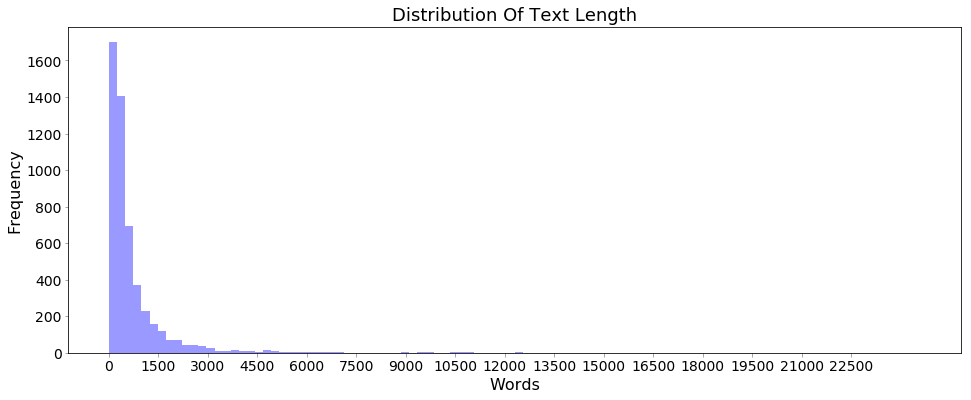

In [122]:
text_list = list(df['selftext'])
posts_length = [len(text_list[i]) for i in range(len(df))]
plt.figure(figsize = (16,6), facecolor = "white")
sns.distplot(posts_length, kde = False, bins = 100, color = "blue")
plt.title("Distribution Of Text Length", size = 18, color = 'black')
plt.xlabel("Words", size = 16, color = 'black')
plt.ylabel("Frequency", size = 16, color = 'black')
plt.xticks(np.arange(0,23500,1500), size = 14, color = 'black')
plt.yticks(size = 14, color = 'black');

## Part 3

In [33]:
df = pd.read_csv('reddit_filtered.tsv', sep='\t')
df.head()

,id,author,title,selftext,link_flair_css_class
0,g77jb6,triary95,Online money making,"Hello!\nSo given the pandemic and WFH, as a st...",Business Finance Policy
1,g77cen,MuseOfZeus,Please download Better call Saul episode 9 and 10,Hello guy! Can somebody be kind enough to down...,AskIndia
2,g779xw,metheist,Recommendations for a decent mid-premium price...,Hey there.\nI was planning to buy a decent mid...,Non-Political
3,g76vcm,BigBulkemails,UP to bring back migrant workers stranded in o...,The workers will be quarantined for 14 days an...,Politics
4,g76ejf,0Kysh0,Is there a customer care email address for Axi...,Their online chat is non-functional and there'...,AskIndia


In [35]:
df = df[(df['link_flair_css_class'] == 'AskIndia') | (df['link_flair_css_class'] == 'Coronavirus') | (df['link_flair_css_class'] == 'Non-Political') | (df['link_flair_css_class'] == 'Politics') | (df['link_flair_css_class'] == 'Policy Economy')]
df['text'] = df['title'] + ' ' + df['selftext']
df.head()

,id,author,title,selftext,link_flair_css_class,text
1,g77cen,MuseOfZeus,Please download Better call Saul episode 9 and 10,Hello guy! Can somebody be kind enough to down...,AskIndia,Please download Better call Saul episode 9 and...
2,g779xw,metheist,Recommendations for a decent mid-premium price...,Hey there.\nI was planning to buy a decent mid...,Non-Political,Recommendations for a decent mid-premium price...
3,g76vcm,BigBulkemails,UP to bring back migrant workers stranded in o...,The workers will be quarantined for 14 days an...,Politics,UP to bring back migrant workers stranded in o...
4,g76ejf,0Kysh0,Is there a customer care email address for Axi...,Their online chat is non-functional and there'...,AskIndia,Is there a customer care email address for Axi...
6,g762u0,ThinkingIndian,Is there any way to buy a new laptop during lo...,My old laptop is giving lot of trouble while w...,AskIndia,Is there any way to buy a new laptop during lo...


In [48]:
def preprocess(input_string):
    input_string = re.sub(r'@\w+', " usermention ", input_string) #for removing mention
    input_string = re.sub(r'#\w+'," ", input_string) #for removing hashtags
    input_string = re.sub(r'\d'," ", input_string) #for removing any number
    input_string = re.sub(r"http\S+", " ", input_string) #for removing the links
    input_string = re.sub(r'www\S+', " ", input_string)
    #input_string = input_string.translate(table) #for removing punctuations
    #input_string = input_string.translate(table_2) #for removing punctuations
    input_string = re.sub(r'[^\w]', ' ', input_string)
    input_string = re.sub(r' +', " ", input_string) #for removing extra whitespaces
    input_string = input_string.lower()
    return input_string

In [54]:
df['text'] = df['text'].apply(lambda x: preprocess(x))

In [55]:
def plot_most_frequent_words(dataframe):
    fig   = plt.figure(figsize   = (24,20), facecolor = "white")
    sns.barplot(x       = 0,
                y       = dataframe.index,
                data    = dataframe,
                palette = "deep")
    # Setting the graph parameters
    plt.title("Most Common Words From Posts", size = 20)
    plt.xlabel("Number Of Occurences", size = 18)
    plt.ylabel("Word", size = 18)
    plt.xticks(size = 16)
    plt.yticks(size = 17)

In [56]:
# Instantiating the count vectorizer

vectorizer = CountVectorizer()

# Masking the vectorizer with English stop words

cvec_posts     = CountVectorizer(stop_words = "english")

### Count Vectors

In [57]:
vec_posts = cvec_posts.fit_transform(df["text"])

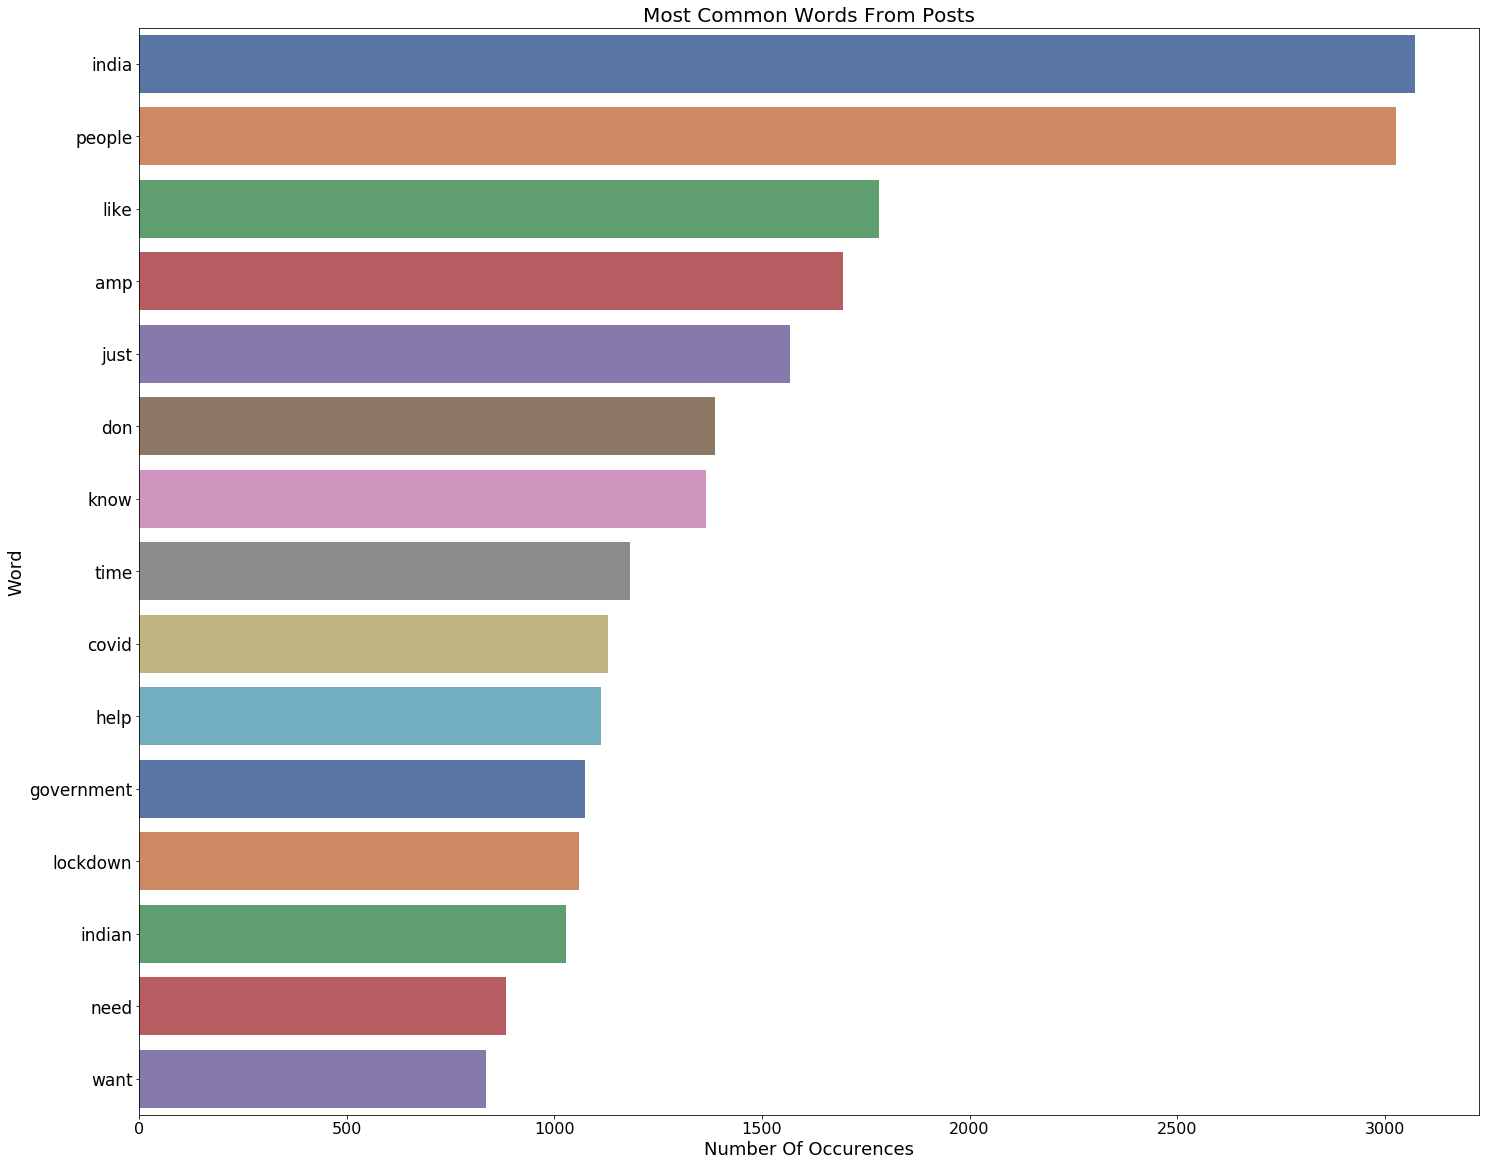

In [58]:
posts_vectorized = pd.DataFrame(vec_posts.toarray(), columns = cvec_posts.get_feature_names())
vectorized_posts = pd.DataFrame(posts_vectorized.sum().sort_values(ascending = False).head(15))
plot_most_frequent_words(vectorized_posts)

In [59]:
stopwords = stopwords.words('english')

In [61]:
lemmatizer = WordNetLemmatizer()
tokenizer  = RegexpTokenizer(r'\w+')
# Setting up the lemmatizer
lemmatized_posts = []

for post in df["text"]:
    tokens = tokenizer.tokenize(post)
    post   = [lemmatizer.lemmatize(post) for post in tokens]
    lemmatized_posts.append(" ".join(post))
    
# Appending the lemmatized posts to the dataframe

df["lemmatized_text"] = lemmatized_posts

### TfIdf with Word2Vec vectors

In [69]:
w2v_model = Word2Vec(min_count=0,
                     window=3,
                     size=100,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=4)

In [70]:
texts = df['text'].to_list()
sentences = []
embed_length = 100
for ii in range(len(texts)):
    tmp_sentences = [re.sub(pattern=r'[\!"#$%&\*+,-./:;<=>?@^_`()|~=]', 
                        repl='', 
                        string=x
                       ).strip().split(' ') for x in texts[ii].split('\n')]
    tmp_sentences = [x.lower().replace("'","") for x in tmp_sentences[0] if x != '']
#     print(tmp_sentences)
    sentences.append(tmp_sentences)

In [71]:
phrases = Phrases(sentences)
bigram = Phraser(phrases)
sentences = list(bigram[sentences])

In [72]:
w2v_model.build_vocab(sentences, progress_per=10000)

In [73]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(8640717, 17155860)

In [79]:
sentences_for_tf = []
for i in sentences:
    sentences_for_tf.append(" ".join(i))

In [80]:
tfidf_vect = TfidfVectorizer()
X = tfidf_vect.fit_transform(sentences_for_tf)

In [82]:
w2v_model.wv.save_word2vec_format('/home/himanshu/Documents/4thYear/midas/embed_model.bin', binary=True)

In [84]:
w2v_model = KeyedVectors.load_word2vec_format('/home/himanshu/Documents/4thYear/midas/embed_model.bin', binary=True)

### OOV Embedding

In [88]:
oov_embed = [0.0]*embed_length
for i in sentences:
    for word in i:
        if word in w2v_model:
            oov_embed += w2v_model[word]
oov_embed = oov_embed/len(set(w2v_model.wv.vocab))

/home/himanshu/bdpenv/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



## Calculating Sentence Embeddings

In [100]:
sent_embed = []
invoc_words = (set(tfidf_vect.vocabulary_).intersection(set(w2v_model.wv.vocab)))
voc = tfidf_vect.vocabulary_
for i in df['text']:
    em = [0.0]*embed_length
    su = 0.0
    for word in i.split(" "):
#         print(word)
        word = word.lower()
        if word in invoc_words:
            su += tfidf_vect.idf_[voc[word]]
            em += (tfidf_vect.idf_[voc[word]]*w2v_model[word])
        elif word in voc:
            em += oov_embed
            su += tfidf_vect.idf_[voc[word]]
        else:
            em += oov_embed
            su += 1
    if(su == 0.0):
        print(i)
    sent_embed.append(em/su)
#     print(sent_embed[i])
#     break

/home/himanshu/bdpenv/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



In [107]:
labels = df['link_flair_css_class']

In [121]:
X_train, X_test, y_train, y_test = train_test_split(sent_embed, labels)

## MLP Classifier

In [143]:
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
x_pred = mlp.predict(X_test)
print(metrics.accuracy_score(y_test,x_pred))

/home/himanshu/bdpenv/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



0.5633561643835616


In [120]:
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
x_pred = mlp.predict(X_train)
print(metrics.accuracy_score(y_train,x_pred))

4671

In [139]:
linreg = LogisticRegression(multi_class = 'multinomial', solver='saga')
linreg.fit(X_train, y_train)
x_pred = linreg.predict(X_train)
print(metrics.accuracy_score(y_train,x_pred))

0.5632315158435627


/home/himanshu/bdpenv/lib/python3.5/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [133]:
mlp.classes_

array(['AskIndia', 'Coronavirus', 'Non-Political', 'Policy Economy',
       'Politics'], dtype='<U14')

## XGBoost

In [206]:
clf = xgb.XGBClassifier(max_depth=20, objective='multi:softprob', n_estimators=1000, num_classes=5)

In [207]:
clf.fit(pd.DataFrame(X_train), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=20, min_child_weight=1, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None, num_classes=5,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [208]:
y_pred = clf.predict(pd.DataFrame(X_test))

In [209]:
metrics.accuracy_score(y_test,y_pred)

0.5813356164383562